# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 03/17/2025

This script performs the following tasks:

1. Loads the database containing processed CFS forecast data.
2. Passes the forecast data through the trained model(s).
3. Generates an ensemble of CNBS forecasts for each of the Great Lakes.
4. Saves the forecasts to a database and/or CSV file.
5. Creates a figure with time series plots and exports it as a PNG file.

The script requires the following files:
- cfs_forecast_data.db
- x_scaler.joblib
- y_scaler.joblib

And at least one or more of the following trained models:
- GP_trained_model.joblib
- RF_trained_model.joblib
- LR_trained_model.joblib
- NN_trained_model.joblib

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
import calendar
import os
import sys

In [ ]:
# Add the path to the src directory (two levels up)
sys.path.append(os.path.abspath('../../'))
from src.data_processing import predict_cnbs, add_df_to_db
from src.hydro_utils import convert_mm_to_cms

# User Input

In [63]:
# Directory where the repository is cloned
path_to_repo = '/Users/ljob/Desktop/'

# Path to data directory
dir = path_to_repo + 'cnbs-predictor-1/data/'

# Path to input CFS forecast database
cfs_database = path_to_repo + 'cfs_forecast_data.db'

# Path to save CNBS forecast output to a database
cnbs_database = path_to_repo + 'cnbs_forecast.db'

# Path to saved scalers
x_scaler = dir + 'input/x_scaler.joblib'
y_scaler = dir + 'input/y_scaler.joblib'

# Define directory to trained models to use along with their paths
models_info = [{'model': 'GP', 'path': dir + 'input/GP_trained_model.joblib'},
               {'model': 'RF', 'path': dir + 'input/RF_trained_model.joblib'},
               {'model': 'LR', 'path': dir + 'input/LR_trained_model.joblib'},
               {'model': 'NN', 'path': dir + 'input/NN_trained_model.joblib'}]

# Surface area [m2] for each region based on the mask file
lake_areas = {
    'erie': 18596386416.712486, 
    'ontario': 15569248531.837788, 
    'michigan-huron': 123626283030.46616, 
    'superior': 78288645587.81192
    }
land_areas = {
    'erie': 81902183517.35063,
    'ontario': 64465190376.66068,
    'michigan-huron': 236478938454.17358,
    'superior': 123736048741.43369}

# Begin Script

In [64]:
# Create a connection to the SQLite database
conn = sqlite3.connect(cfs_database)

# Define the query to get all the data
query = '''
SELECT * FROM cfs_forecast_data
'''

# Execute the query and fetch the data into a DataFrame
data = pd.read_sql(query, conn)

# Close the connection once done
conn.close()

data.set_index(['cfs_run', 'month', 'year'], drop=True, inplace=True)

In [65]:
# This creates 1 column with a variable name that combines column names from the database
# It just makes it simplier for the moment to call the data
data['variable'] = data['lake'] + '_' + data['surface_type'] + '_' + data['component']

In [87]:
# The variable names based on the above step in the order that they need to be in based on the order of variables during the training step
variables = ['superior_lake_precipitation', 'erie_lake_precipitation', 'ontario_lake_precipitation', 'michigan-huron_lake_precipitation', 
             'superior_land_precipitation', 'erie_land_precipitation', 'ontario_land_precipitation', 'michigan-huron_land_precipitation', 
             'superior_lake_evaporation', 'erie_lake_evaporation', 'ontario_lake_evaporation', 'michigan-huron_lake_evaporation',
             'superior_land_evaporation', 'erie_land_evaporation', 'ontario_land_evaporation', 'michigan-huron_land_evaporation',
             'superior_lake_air_temperature', 'erie_lake_air_temperature', 'ontario_lake_air_temperature', 'michigan-huron_lake_air_temperature', 
             'superior_land_air_temperature', 'erie_land_air_temperature', 'ontario_land_air_temperature', 'michigan-huron_land_air_temperature'
             ] + [f'month_{i}' for i in range(1, 13)]

data = data.reset_index()

X = data.pivot_table(index=['cfs_run', 'year', 'month'], columns='variable', values='value [mm]')
# Remove column level name
X.columns.name = None

# Extract month from index and one-hot encode
X['month'] = X.index.get_level_values('month')
X = pd.get_dummies(X, columns=['month'], prefix='month')

# Ensure all month columns exist
for i in range(1, 13):
    col = f'month_{i}'
    if col not in X.columns:
        X[col] = 0

# Reorder columns to match training order
X = X[variables]

# For any reason, in a worse case scenario and there are NaNs (which there would never ever be missing data), drop the rows that include them
# Check first to see if there are NaN values in the DataFrame
if X.isna().any().any():
    # Remove rows with NaN values
    print("NANs were found in the input dataset. Removing them before continuing.")
    X = X.dropna(how='any')

NANs were found in the input dataset. Removing them before continuing.


Run CFS data through the trained models

In [67]:
# Initialize an empty dataframe to store predictions by model name
model_predictions = []

# Process each model and add to DB
for model_info in models_info:
    model_name = model_info['model']
    df_y = predict_cnbs(X, x_scaler, y_scaler, models_info, model_name)
    if df_y is not None:
        # Store the predictions in the dataframe
        df_y['model'] = model_name
        model_predictions.append(df_y)

df = pd.concat(model_predictions, ignore_index=False).reset_index()


4451/4451 ━━━━━━━━━━━━━━━━━━━━ 1s 175us/step


Format the CNBS forecasts, calculate values from mm to cms and add data to a database

In [ ]:
# Format the data so it is organized and ready to add to the database
melt_df = df.melt(id_vars=['model', 'cfs_run', 'month', 'year'], var_name='lake_cnbs', value_name='value [mm]')
melt_df[['lake', 'component']] = melt_df['lake_cnbs'].str.split('_', expand=True)
melt_df_formatted = melt_df.drop(columns=['lake_cnbs']).loc[:, ['cfs_run', 'month', 'year', 'model', 'lake', 'component', 'value [mm]']]
melt_df_formatted = melt_df_formatted[['cfs_run', 'month', 'year', 'model', 'lake', 'component', 'value [mm]']]
melt_df_formatted = melt_df_formatted.sort_values(by=['cfs_run', 'month', 'year', 'model', 'lake']).set_index(['cfs_run', 'month', 'year'])
df_new = convert_mm_to_cms(melt_df_formatted)
add_df_to_db(cnbs_database, 'cnbs_forecast', df_new)

Calculate the median of each month forecast by model

In [ ]:
df_y_model_median = df_new.groupby(['year', 'month', 'model', 'lake', 'component'])[['value [mm]', 'value [cms]']].median().round(3)
add_df_to_db(cnbs_database, 'cnbs_forecast_model_median', df_y_model_median)

Calculate the median of each month from all the model ensemble forecasts

In [70]:
# Get the median value for each forecast month
df_y_median = df_new.groupby(['year', 'month', 'lake', 'component'])[['value [mm]', 'value [cms]']].mean().round(3).reset_index()

# Rename columns
df_y_median.rename(columns={'year': 'forecast_year', 'month': 'forecast_month'}, inplace=True)

# Set a "current year" and "current month" to make tracking the forecast easier
df_y_median['current_year'] = df_y_median['forecast_year'][0]
df_y_median['current_month'] = df_y_median['forecast_month'][0]

# Only keep the columns we need and in a particulat order
df_y_median = df_y_median[['current_year', 'current_month', 'forecast_year', 'forecast_month', 'lake', 'component', 'value [mm]', 'value [cms]']]

# Save to a CSV [mm]
df_y_median.to_csv(f'{dir}forecast/CNBS_forecast.csv', sep='\t', index=False)

In [71]:
# Create a column that is forecast date in YYYY_MM. This will just make is easier to pivot the table
df_y_median['forecast'] = df_y_median['forecast_year'].astype(str) + '_' + df_y_median['forecast_month'].astype(str).str.zfill(2)

# Make sure they are sorted by the forecast date
df_test = df_y_median.sort_values(['current_year', 'current_month', 'lake', 'forecast'])

# Pivot the table so the forecast date is in columns instead of rows
df_pivoted = df_test.pivot_table(
    index=['current_year', 'current_month', 'lake', 'component'],
    columns='forecast',
    values='value [cms]'
    ).reset_index()
df_pivoted.columns.name = None

In [72]:
# Get the forecast columns
forecast_cols = df_pivoted.columns.difference(['current_year', 'current_month', 'lake', 'component'])

# Sort the data
forecast_cols_sorted = sorted(forecast_cols)

# Rename columns to month_1, month_2, ...
rename_dict = {old: f'month_{i+1}' for i, old in enumerate(forecast_cols_sorted)}
df_pivoted = df_pivoted.rename(columns=rename_dict)

In [73]:
# Open L2 data 
sup_evap = pd.read_csv(dir + 'l2swbm/superiorEvap_MonthlyRun.csv')
sup_runoff = pd.read_csv(dir + 'l2swbm/superiorRunoff_MonthlyRun.csv')
sup_precip = pd.read_csv(dir + 'l2swbm/superiorPrecip_MonthlyRun.csv')

eri_evap = pd.read_csv(dir + 'l2swbm/erieEvap_MonthlyRun.csv')
eri_runoff = pd.read_csv(dir + 'l2swbm/erieRunoff_MonthlyRun.csv')
eri_precip = pd.read_csv(dir + 'l2swbm/eriePrecip_MonthlyRun.csv')

ont_evap = pd.read_csv(dir + 'l2swbm/ontarioEvap_MonthlyRun.csv')
ont_runoff = pd.read_csv(dir + 'l2swbm/ontarioRunoff_MonthlyRun.csv')
ont_precip = pd.read_csv(dir + 'l2swbm/ontarioPrecip_MonthlyRun.csv')

mih_evap = pd.read_csv(dir + 'l2swbm/miHuronEvap_MonthlyRun.csv')
mih_runoff = pd.read_csv(dir + 'l2swbm/miHuronRunoff_MonthlyRun.csv')
mih_precip = pd.read_csv(dir + 'l2swbm/miHuronPrecip_MonthlyRun.csv')

In [ ]:
l2_obs = pd.DataFrame({
    'year_month': pd.to_datetime(eri_evap['Year'].astype(int).astype(str) + '-' + eri_evap['Month'].astype(int).astype(str), format='%Y-%m').dt.strftime('%Y-%m'),
    'superior_evaporation_obs': sup_evap['Median'],
    'superior_precipitation_obs': sup_precip['Median'],
    'superior_runoff_obs': sup_runoff['Median'],
    #'superior_cnbs_obs': sup_precip['Median']+sup_runoff['Median']-sup_evap['Median'],
    'erie_evaporation_obs': eri_evap['Median'],
    'erie_precipitation_obs': eri_precip['Median'],
    'erie_runoff_obs': eri_runoff['Median'],
    #'erie_cnbs_obs': eri_precip['Median']+eri_runoff['Median']-eri_evap['Median'],
    'ontario_evaporation_obs': ont_evap['Median'],
    'ontario_precipitation_obs': ont_precip['Median'],
    'ontario_runoff_obs': ont_runoff['Median'],
    #'ontario_cnbs_obs': ont_precip['Median']+ont_runoff['Median']-ont_evap['Median'],
    'michigan-huron_evaporation_obs': mih_evap['Median'],
    'michigan-huron_precipitation_obs': mih_precip['Median'],
    'michigan-huron_runoff_obs': mih_runoff['Median'],
    #'michigan-huron_cnbs_obs': mih_precip['Median']+mih_runoff['Median']-mih_evap['Median'],
})

In [75]:
median_df = df.groupby(['year', 'month', 'model']).mean(numeric_only=True).reset_index()

In [76]:
median_df['year_month'] = median_df['year'].astype(str) + '-' + median_df['month'].astype(str).str.zfill(2)

In [78]:
def format_observed_data(df):
    # Melt the observed data to long format and create the 'year_month' column in a single step
    observed_df = df.melt(id_vars=['Year'], var_name='Month', value_name='Observed')

    # Combine 'Year' and 'Month' into a proper 'year_month' format and convert to datetime in one step
    observed_df['year_month'] = (pd.to_datetime(observed_df['Year'].astype(str) + '-' + observed_df['Month'].str[1:4], format='%Y-%b')).dt.strftime('%Y-%m')
    # Convert year_month to datetime
    observed_df['year_month'] = pd.to_datetime(observed_df['year_month'])

    # Sort by 'year_month' for proper chronological order
    observed_df = observed_df.sort_values(by='year_month')
    observed_df = observed_df[['year_month', 'Observed']].reset_index(drop=True)

    observed_df.replace(-99990.0, np.nan, inplace=True)
    observed_df = observed_df.dropna()

    return observed_df

In [79]:
# Load the GLCC observed data
observed_sup = pd.read_csv(dir + 'glcc/LakeSuperior_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)
observed_mih = pd.read_csv(dir + 'glcc/LakeMichiganHuron_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)
observed_eri = pd.read_csv(dir + 'glcc/LakeErie_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)
observed_ont = pd.read_csv(dir + 'glcc/LakeOntario_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)

df_obs_sup = format_observed_data(observed_sup)
df_obs_sup.rename(columns={'Observed': 'superior_cnbs_obs'}, inplace=True)
df_obs_mih = format_observed_data(observed_mih)
df_obs_mih.rename(columns={'Observed': 'michigan-huron_cnbs_obs'}, inplace=True)
df_obs_eri = format_observed_data(observed_eri)
df_obs_eri.rename(columns={'Observed': 'erie_cnbs_obs'}, inplace=True)
df_obs_ont = format_observed_data(observed_ont)
df_obs_ont.rename(columns={'Observed': 'ontario_cnbs_obs'}, inplace=True)

df_obs_merged = pd.merge(df_obs_sup, df_obs_mih, on="year_month", how="outer")
df_obs_merged = pd.merge(df_obs_merged, df_obs_eri, on="year_month", how="outer")
df_obs_merged = pd.merge(df_obs_merged, df_obs_ont, on="year_month", how="outer")

# Calculate number of seconds in each month
df_obs_merged['seconds_in_month'] = df_obs_merged['year_month'].apply(
    lambda x: calendar.monthrange(x.year, x.month)[1] * 24 * 60 * 60
    )
    
# Convert m³/s to mm using lake surface areas
for col in df_obs_merged.columns:
    if col.endswith('_cnbs_obs'):
        lake = col.replace('_cnbs_obs', '')
        area = lake_areas.get(lake)
        if area:
            df_obs_merged[col] = df_obs_merged[col] * df_obs_merged['seconds_in_month'] / area * 1000

df_obs_mm = df_obs_merged.drop(columns='seconds_in_month')
df_obs_mm['year_month'] = pd.to_datetime(df_obs_mm['year_month']).dt.strftime('%Y-%m')

In [86]:
df_combined1 = pd.merge(median_df, l2_obs, on=('year_month'), how='left')
df_combined = pd.merge(df_combined1, df_obs_mm, on=('year_month'), how='left')
df_combined = df_combined.dropna()

Plot the forecasts for each component for each lake by model output

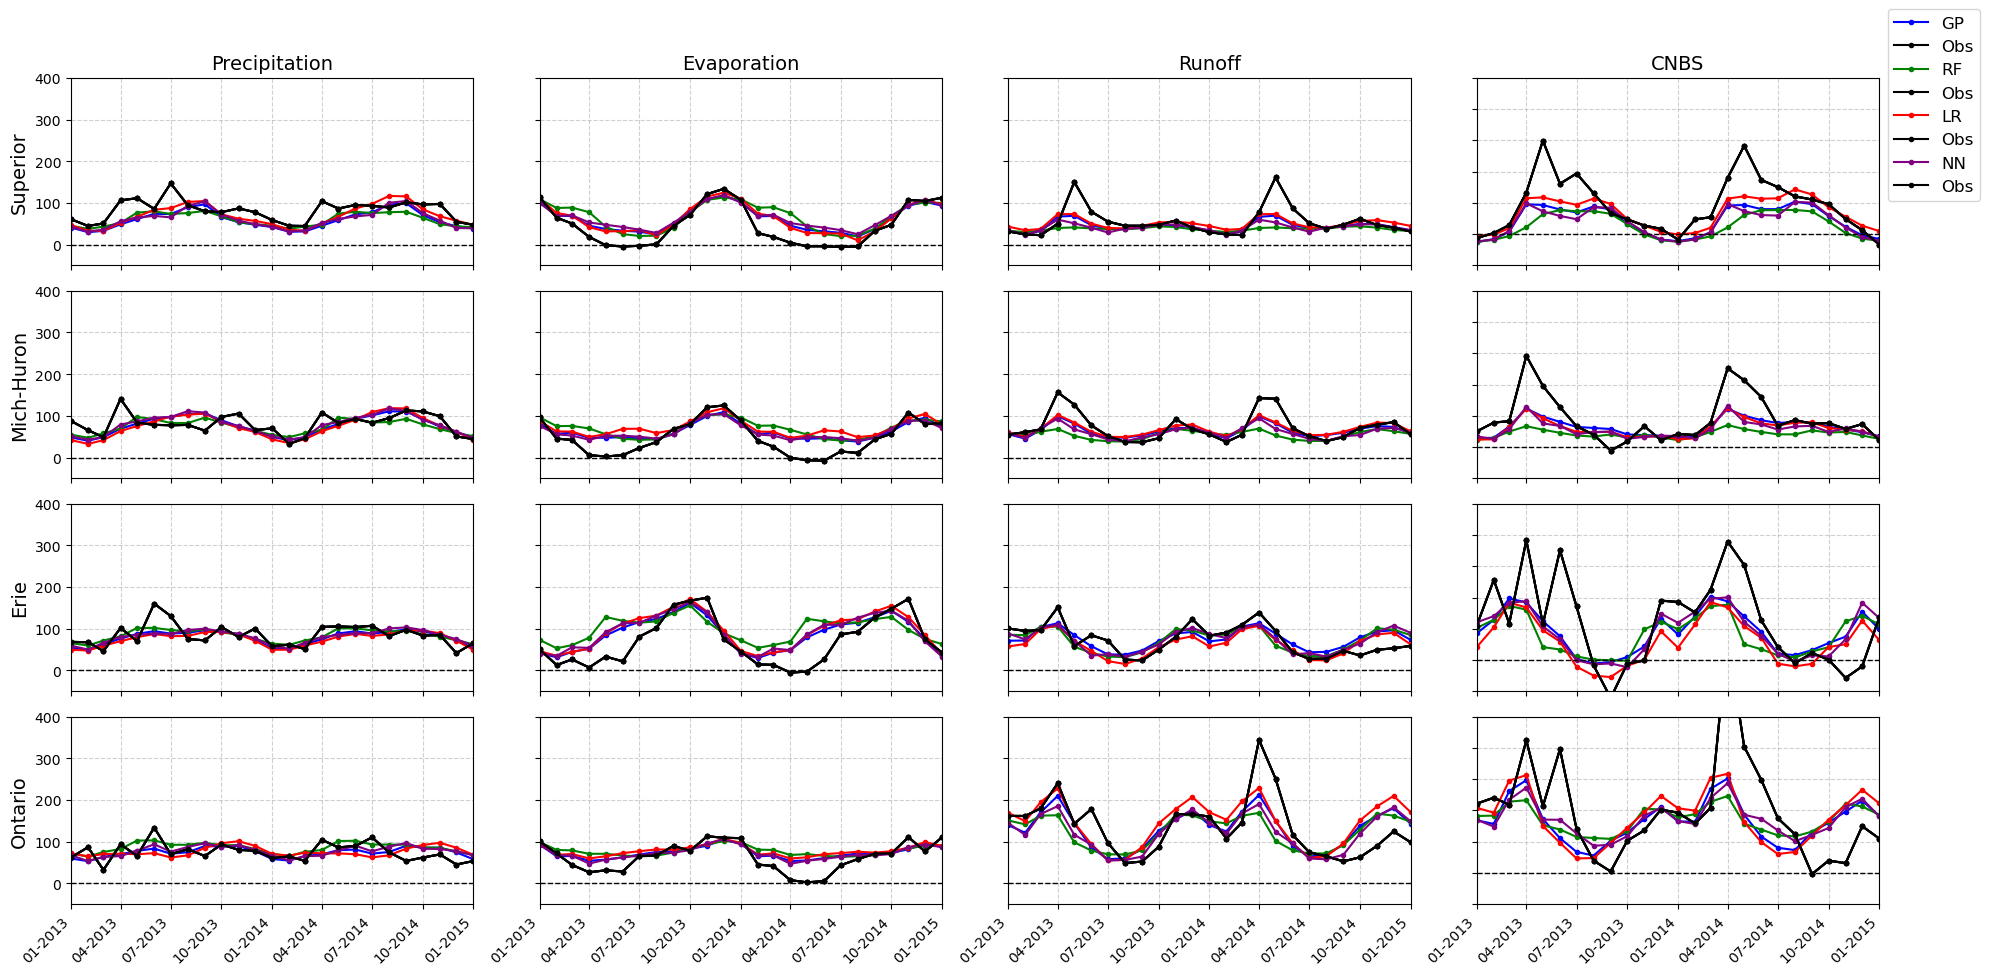

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Define model colors
model_colors = {'GP': 'blue', 'RF': 'green', 'LR': 'red', 'NN': 'purple'}

# Define lake names and components
lakes = ['superior', 'michigan-huron', 'erie', 'ontario']
components = ['precipitation', 'evaporation', 'runoff', 'cnbs']
titles = ['Precipitation', 'Evaporation', 'Runoff', 'CNBS']
ylabels = ['Superior', 'Mich-Huron', 'Erie', 'Ontario']

# Create subplot grid
fig, axs = plt.subplots(4, 4, figsize=(20, 10))
axs = axs.reshape(4, 4)

# Loop through all combinations of lake and component
for row, lake in enumerate(lakes):
    for col, comp in enumerate(components):
        ax = axs[row, col]
        column = f'{lake}_{comp}'
        obs_column = f'{column}_obs'

        for model_info in models_info:
            model_name = model_info['model']
            model_df = df_combined[df_combined['model'] == model_name].copy()
            model_df['date'] = pd.to_datetime(model_df['year_month'])

            # Plot model prediction
            ax.plot(model_df['date'], model_df[column], marker='o', markersize=3,
                    color=model_colors[model_name], label=model_name)
            # Plot observations
            ax.plot(model_df['date'], model_df[obs_column], marker='o', markersize=3,
                    color='black', linewidth=1.5, label='Obs')

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_yticks(np.arange(-1000, 1000, 100))

        # Set titles and labels
        if row == 0:
            ax.set_title(titles[col], fontsize=14)
        if row == 3:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax.tick_params(axis='x', rotation=45)
            for label in ax.get_xticklabels():
                label.set_horizontalalignment('right')
        else:
            ax.set_xticklabels([])

        if col == 0:
            ax.set_ylabel(ylabels[row], fontsize=14)
        else:
            ax.set_yticklabels([])
        if col == 3:
            ax.set_ylim(-100, 500)
        else:
            ax.set_ylim(-50, 400)

# Add legend once
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3), fontsize=12)

start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2015-01-01')

for ax_row in axs:
    for ax in ax_row:
        ax.set_xlim(start_date, end_date)

# Save and show plot
plt.tight_layout()
plt.savefig('CNBS_forecasts.png', dpi=300)
plt.show()

In [83]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from properscoring import crps_ensemble

def calculate_total_skill(df, variables, model, label):
    obs_cols = [v + '_obs' for v in variables]
    
    df = df[df['model'] == model]

    # Combine and drop NaNs
    valid_rows = df[variables + obs_cols].dropna()
    y_pred = valid_rows[variables].values.flatten()
    y_true = valid_rows[obs_cols].values.flatten()

    # Standardize
    scaler = StandardScaler()
    y_true_std = scaler.fit_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_std = scaler.transform(y_pred.reshape(-1, 1)).flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true_std, y_pred_std))
    r2 = r2_score(y_true_std, y_pred_std)
    bias = np.mean(y_pred - y_true)
    variance = np.var(y_pred)
    crps = np.mean(crps_ensemble(y_true, y_pred[:, None]))  # Ensemble shape [n, 1]

    return pd.DataFrame([{
        'group': label,
        'model': model,
        'rmse': round(rmse, 3),
        'r2': round(r2, 3),
        'bias': round(bias, 3),
        'variance': round(variance, 3),
        'crps': round(crps, 3)
    }])

In [85]:
all = ['precipitation', 'evaporation', 'runoff', 'cnbs']
components = ['precipitation', 'evaporation', 'runoff']
lakes = ['erie', 'superior', 'ontario', 'michigan-huron']

# Variable groups
wb_vars = [f'{lake}_{comp}' for lake in lakes for comp in all]
comp_vars = [f'{lake}_{comp}' for lake in lakes for comp in components]
precip_vars = [f'{lake}_precipitation' for lake in lakes]
evap_vars = [f'{lake}_evaporation' for lake in lakes]
runoff_vars = [f'{lake}_runoff' for lake in lakes]
cnbs_vars = [f'{lake}_cnbs' for lake in lakes]

# Calculate total skill
gp_wb_skill = calculate_total_skill(df_combined, wb_vars, 'GP', 'All')
gp_c_skill = calculate_total_skill(df_combined, comp_vars, 'GP', 'Components')
gp_p_skill = calculate_total_skill(df_combined, precip_vars, 'GP', 'Precipitation')
gp_e_skill = calculate_total_skill(df_combined, evap_vars, 'GP', 'Evaporation')
gp_r_skill = calculate_total_skill(df_combined, runoff_vars, 'GP', 'Runoff')
gp_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'GP', 'CNBS')

rf_wb_skill = calculate_total_skill(df_combined, wb_vars, 'RF', 'All')
rf_c_skill = calculate_total_skill(df_combined, comp_vars, 'RF', 'Components')
rf_p_skill = calculate_total_skill(df_combined, precip_vars, 'RF', 'Precipitation')
rf_e_skill = calculate_total_skill(df_combined, evap_vars, 'RF', 'Evaporation')
rf_r_skill = calculate_total_skill(df_combined, runoff_vars, 'RF', 'Runoff')
rf_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'RF', 'CNBS')

lr_wb_skill = calculate_total_skill(df_combined, wb_vars, 'LR', 'All')
lr_c_skill = calculate_total_skill(df_combined, comp_vars, 'LR', 'Components')
lr_p_skill = calculate_total_skill(df_combined, precip_vars, 'LR', 'Precipitation')
lr_e_skill = calculate_total_skill(df_combined, evap_vars, 'LR', 'Evaporation')
lr_r_skill = calculate_total_skill(df_combined, runoff_vars, 'LR', 'Runoff')
lr_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'LR', 'CNBS')

nn_wb_skill = calculate_total_skill(df_combined, wb_vars, 'NN', 'All')
nn_c_skill = calculate_total_skill(df_combined, comp_vars, 'NN', 'Components')
nn_p_skill = calculate_total_skill(df_combined, precip_vars, 'NN', 'Precipitation')
nn_e_skill = calculate_total_skill(df_combined, evap_vars, 'NN', 'Evaporation')
nn_r_skill = calculate_total_skill(df_combined, runoff_vars, 'NN', 'Runoff')
nn_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'NN', 'CNBS')

# Combine results
all_skill = pd.concat([gp_wb_skill, gp_c_skill, gp_p_skill, gp_e_skill, gp_r_skill, gp_cnbs_skill, 
                       rf_wb_skill, rf_c_skill, rf_p_skill, rf_e_skill, rf_r_skill, rf_cnbs_skill, 
                       lr_wb_skill, lr_c_skill, lr_p_skill, lr_e_skill, lr_r_skill, lr_cnbs_skill, 
                       nn_wb_skill, nn_c_skill, nn_p_skill, nn_e_skill, nn_r_skill, nn_cnbs_skill
                       ])
print(all_skill)

           group model   rmse     r2    bias  variance    crps
0            All    GP  0.705  0.503  -4.556  2292.619  34.630
0     Components    GP  0.644  0.586   2.318  1045.869  22.418
0  Precipitation    GP  0.952  0.093  -3.698   371.493  20.807
0    Evaporation    GP  0.640  0.590  13.735   921.261  23.926
0         Runoff    GP  0.580  0.664  -3.082  1824.206  22.520
0           CNBS    GP  0.753  0.432 -25.177  5844.911  71.268
0            All    RF  0.811  0.343  -5.893  1967.239  39.991
0     Components    RF  0.777  0.396   4.037   939.307  26.114
0  Precipitation    RF  0.969  0.060   0.857   307.837  21.347
0    Evaporation    RF  0.856  0.268  20.746   843.001  31.173
0         Runoff    RF  0.701  0.508  -9.493  1636.126  25.822
0           CNBS    RF  0.854  0.270 -35.680  5041.264  81.623
0            All    LR  0.725  0.475  -2.721  2860.420  35.405
0     Components    LR  0.680  0.538   5.305  1329.158  23.527
0  Precipitation    LR  0.968  0.064  -3.714   390.562 